# 21點樸克牌(Blackjack)之值循環(Value Iteration)

In [1]:
# 載入相關套件
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import sys
from collections import defaultdict
import matplotlib

matplotlib.style.use('ggplot') # 設定繪圖的風格

In [2]:
# 環境
env = BlackjackEnv()

In [3]:
# ε-greedy策略
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        # 每個行動的機率初始化，均為 ε / n
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        # 最佳行動的機率再加 1 - ε 
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [9]:
# 值循環函數
def value_iteration(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    returns_sum = defaultdict(float)    # 記錄每一個狀態的報酬
    returns_count = defaultdict(float)  # 記錄每一個狀態的訪問個數
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # 行動值函數
    
    # 採用 ε-greedy策略
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    # 實驗 N 回合
    for i_episode in range(1, num_episodes + 1):
        # 每 1000 回合顯示除錯訊息
        if i_episode % 1000 == 0:
            print(f"\r {i_episode}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除畫面

        # 回合(episode)資料結構為陣列，每一項目含 state, action, reward
        episode = []
        state = env.reset()
        # 開始依策略玩牌，最多 100 步驟，中途分出勝負即結束
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # 找出走過的所有狀態
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            # (狀態, 行動)組合初始化
            sa_pair = (state, action)
            # 找出每一步驟內的首次訪問(First Visit)
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # 算累計報酬(G)
            G = sum([x[2]*(discount_factor**i) for i,x in 
                     enumerate(episode[first_occurence_idx:])])
            # 計算行動值函數
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
    return Q, policy

In [7]:
# 執行值循環
Q, policy = value_iteration(env, num_episodes=500000, epsilon=0.1)

 500000/500000回合.

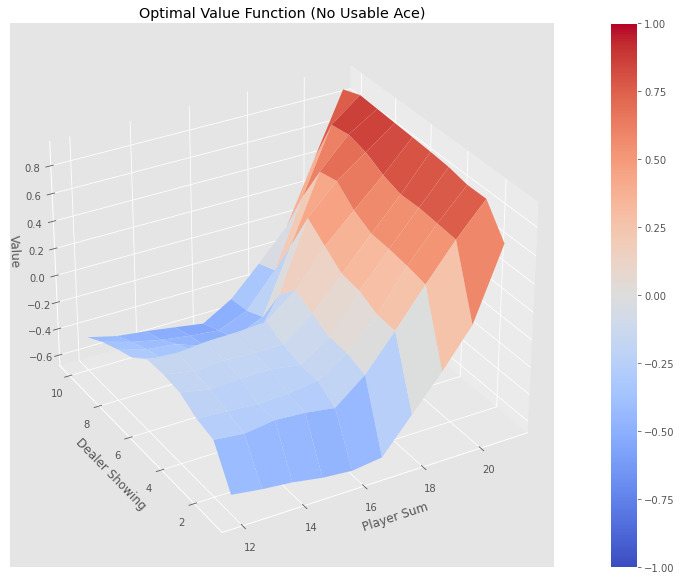

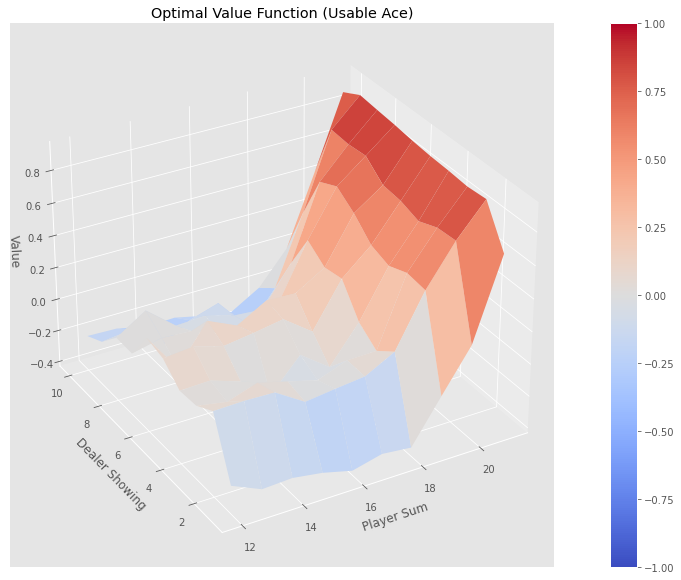

In [8]:
# 顯示結果
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")